# Assignment 2 - SVM and Signature Verification
author: Chen Cheng

The SVM learning process should result in a model that can distinguish between your signature and any forged one with a satisfying accuracy - i.e., **binary classification** .

Data files that are made use of in this assignment:
- **sig/png.csv**: csv file containing all the image information, especially the *path* and *label*
- **sig/original**: the folder containing all the images, which are English signatures of the name "Caspar". *135 of them are genuine and 82 of them are forged*. We will use this dataset to train the model


## Loading of data
- import the data from csv file into *"image_path"* array, shuffle it
- get the number of samples, number of genuine signatures and number of forged signatures

In [1]:
import csv
import random
with open('sig/png.csv', 'r') as csvfile:
    lines = csv.reader(csvfile)
    image_path=list(lines)

#delete the first line, which is the column names
del image_path[0]
num_sample = len(image_path)

print("size of data: ",num_sample)
random.shuffle(image_path)

num_genuine = 0
num_forged = 0

for i in range(num_sample):
    if image_path[i][4] == 'genuine':
        num_genuine += 1
    else:
        num_forged += 1

print("number of genuine data:",num_genuine)
print("number of forged data:",num_forged)

size of data:  217
number of genuine data: 135
number of forged data: 82


## functions to do image processing
Make use of the functions that are provided

In [2]:
import numpy as np
import json
from matplotlib import (pyplot as plt, patches as patches)
from PIL import Image # pip install pillow
from skimage.filters import threshold_local # pip install scikit-image

# area of bounding box
def rotate_bbox_area(img, deg):
    box = img.rotate(deg, expand=True).getbbox()
    return (box[3] - box[1]) * (box[2] - box[0])
    
def rotate_crop(img, deg, padding=0):
    img_rotate = img.rotate(deg, expand=True, resample=Image.BILINEAR)
    box = img_rotate.getbbox()
    if padding > 0:
        box = np.asarray(box) + [-padding, -padding, +padding, +padding]
    return img_rotate.crop(box)


tol_deg = 10
# smallest bounding box wihin -10~10 degrees rotation
def opt_rotate(img, padding=0):
    opt_deg = np.argmin(
        [rotate_bbox_area(img, i) for i in range(-tol_deg,tol_deg+1)]
        ) - tol_deg
    return rotate_crop(img, opt_deg, padding)

# downsampling
def img_reduce(img, side=28, mode=Image.ANTIALIAS):
    h = side + 1 
    #w = int(side * img.width / img.height) + 1
    w = side + 1
    img_reduced = img.copy()
    # the reduced image size is (w-1, h-1)
    img_reduced.thumbnail((w, h), mode)
    return img_reduced


# convert PIL.Image object to numpy.Array, for training
def img2arr(img):
    return np.asarray(img.getdata(), dtype=np.uint8).reshape(img.height,img.width, -1)
    #return np.asarray(img.getdata(), dtype=np.uint8).reshape(28,28, -1)
    #return np.asarray(img.getdata(), dtype=np.uint8)

# process single signature with transparent background
def process_one(img):
    return img_reduce(opt_rotate(img, padding=1).convert('LA'))

## Get the image data and labels to do the training
- apply the functions above, load and process the images and convert into **1D array**
- store the image data into *data* array and store the corresponding label data into *labels* array (note that I use **0 for genuine and 1 for forged**)
- note that as we need to have a **constant number of attributes** for every sample data to do the training, we throw away some sample data that are too small and restrain the array length to be *319*
- finally we have *175* data samples

In [3]:
# processing signatures collected through web canvas, with transparent background
import random

data = []
labels = []

for i in range(num_sample):
    im = Image.open('sig/'+image_path[i][3]) #relative path to file
    img = im.convert('LA')
    
    #optimally rotate it and reduce the dimension of it
    img_reduced = process_one(img)
    
    #convert the image data to a 2d array and further convert to a 1D array
    img_arr = img2arr(img_reduced)[:,:,-1] # use the alpha channel, highter more opaque
    img_arr = img_arr.ravel()
    
    #if the dimension is too small, throw it away
    if len(img_arr)<319:
        img.close()
        im.close()
        continue
    
    #only append the first 319 values of an image
    data.append(img_arr[:319])
    if image_path[i][4]=='genuine':
        labels.append(0)
    else:
        labels.append(1)
    img.close()
    im.close()

num_sample = len(data)
print("labels: ",labels)
print("data dimension: ",len(data) )
print("labels dimension: ",len(labels))
print("first data length: ",len(data[0]))
print("second data length: ",len(data[1]))


labels:  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0]
data dimension:  175
labels dimension:  175
first data length:  319
second data length:  319


## split the data into training set and testing set
- 1st method: decide on a *split* value (integer), and simply split into first half and second half
- 2nd method: random split, *split* value is a float number indicating the **proportion of training data**

In [4]:
import random

def splitData_simple(split, training_data = [], testing_data = [], training_label = [], testing_label=[]):
    for i in range(0,split):
        training_data.append(data[i])
        training_label.append(labels[i])
    for i in range(split,len(data)):
        testing_data.append(data[i])
        testing_label.append(labels[i])
    
def splitData_random(split, training_data = [], testing_data = [], training_label = [], testing_label=[]):
    for i in range(len(data)):
        if random.random() < split:
            training_data.append(data[i])
            training_label.append(labels[i])
        else:
            testing_data.append(data[i])
            testing_label.append(labels[i])


## svm
*SVC*, *NuSVC* and *LinearSVC* take as input two arrays: 
- an array **X** of size [n_samples, n_features] holding the **training samples**
- an array **y** of class **labels** (strings or integers), size [n_samples]

## svm without any kernel specification
- iterate *5* times and draw a graph to indicate the accuracy everytime
- the concrete results are also printed
- we use both the two ways of splitting the data and test them both

Simple split

iteration 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 0 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 0 ;label: 1
prediction: 0 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 0 

prediction: 0 ;label: 1
prediction: 0 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 0 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 0 ;label: 1
prediction: 0 ;label: 1
prediction: 0 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 0 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 0 ;label: 1
prediction: 0 ;label: 1
prediction: 0 ;label: 1
prediction: 0 ;label: 0

iteration 4
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 0 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
pre

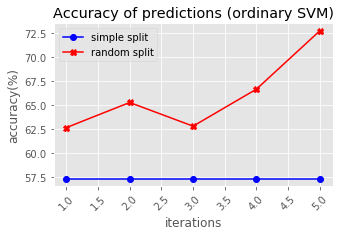

In [8]:
from sklearn import svm
import matplotlib.pyplot as plt

%matplotlib inline

#define the function to analyze the accuracy of prediction
def analyze_prediction(prediction,testing_label):
    num = len(testing_label)
    accuracy = 0.0
    for i in range(0,num):
        print("prediction:",prediction[i],";label:",testing_label[i])
        if prediction[i]==testing_label[i]:
            accuracy+=1
    accuracy/=float(num)
    return accuracy*100.00

#first try fitting without any kernel specification

#first split the data with the simple method:

training_data = []
testing_data = []
training_label = []
testing_label = []

accuracies1 = []
accuracies2 = []
iterations = []

splitData_simple(100, training_data, testing_data, training_label, testing_label)

print("Simple split")
for i in range(5):
    print("\niteration",i+1)
    iterations.append(i+1)
    clf = svm.SVC()
    clf.fit(training_data, training_label) 
    prediction1 = clf.predict(testing_data)
    accuracy = analyze_prediction(prediction1,testing_label)
    accuracies1.append(accuracy)

#then split the data with the random method

print("\nrandom split")
for i in range(5):
    training_data = []
    testing_data = []
    training_label = []
    testing_label = []
    
    splitData_random(100/175, training_data, testing_data, training_label, testing_label)
    print("\niteration",i+1)
    clf = svm.SVC()
    clf.fit(training_data, training_label) 
    prediction2 = clf.predict(testing_data)
    accuracy = analyze_prediction(prediction2,testing_label)
    accuracies2.append(accuracy)

#plot the result
plt.style.use('ggplot')
plt.figure(figsize=(5,3))
plt.title("Accuracy of predictions (ordinary SVM)")
plt.xlabel("iterations")
plt.xticks(rotation=45)
plt.ylabel("accuracy(%)")

plt.plot(iterations,accuracies1,color='b', label="simple split", marker="o")
plt.plot(iterations,accuracies2,color='r',label="random split",marker="X")

plt.legend()
plt.grid(True)

## SVM with linear kernel
- use *GridSearchCV* to find the best parameters
- use *stratifiedShuffleSplit* to find a good split between *training data* and *testing data*
- *n_splits* is set to 5, which means 5 iterations will be done; a graph will also be generated to indicate the accuracy
- as from the above experiment, we already know that random splitting is better than simple splitting, so here we will try the **random** one and **stratified** one

The best parameters are {'C': 0.01, 'gamma': 1.0000000000000001e-09} with a score of 0.87
stratified splitting

iteration 1
prediction: 0 ;label: 0
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 0 ;label: 0
prediction: 1 ;label: 1
prediction: 1 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 1 ;label: 1
prediction: 1 ;label: 0
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 0 ;label: 0
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 1 ;label: 0
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 

prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 1 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 1 ;label: 1
prediction: 1 ;label: 1
prediction: 1 ;label: 0
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 1 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 1 ;label: 0
prediction: 1 ;label: 1
prediction: 1 ;label: 1
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 1 ;label: 1
prediction: 0 ;l

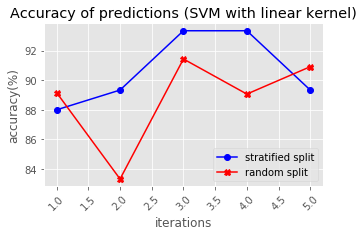

In [12]:
#using linear kernel
from sklearn.svm import SVC 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import numpy as np

#find the best parameters
split = 100
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, train_size=split, test_size=num_sample-split)
grid = GridSearchCV(SVC(kernel='linear'), param_grid=param_grid, cv=cv)
grid.fit(data, labels)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

#actually fit the data and get the result
cv.get_n_splits(data,labels)
clf = SVC(kernel='linear', C=grid.best_params_['C'], gamma=grid.best_params_['gamma'])

#firstly try the stratified one
accuracies1 = []
accuracies2 = []
iterations = [1,2,3,4,5]
iteration = 0

print("stratified splitting")
for train_index, test_index in cv.split(data, labels):
    iteration += 1
    print("\niteration",iteration)
    training_data = []
    testing_data = []
    training_label = []
    testing_label = []
    for i in train_index:
        training_data.append(data[i])
        training_label.append(labels[i])
    for i in test_index:
        testing_data.append(data[i])
        testing_label.append(labels[i])
        
    clf.fit(training_data, training_label)
    prediction2 = clf.predict(testing_data)
    accuracy = analyze_prediction(prediction2,testing_label)
    accuracies1.append(accuracy)

#then try the random splitting

print("\nrandom splitting")
for i in range(5):
    training_data = []
    testing_data = []
    training_label = []
    testing_label = []
    splitData_random(100/175, training_data, testing_data, training_label, testing_label)
    
    print("\niteration",i+1)
    clf.fit(training_data, training_label) 
    prediction2 = clf.predict(testing_data)
    accuracy = analyze_prediction(prediction2,testing_label)
    accuracies2.append(accuracy)
    
#plot the result
plt.style.use('ggplot')
plt.figure(figsize=(5,3))
plt.title("Accuracy of predictions (SVM with linear kernel)")
plt.xlabel("iterations")
plt.xticks(rotation=45)
plt.ylabel("accuracy(%)")

plt.plot(iterations,accuracies1,color='b', label="stratified split", marker="o")
plt.plot(iterations,accuracies2,color='r',label="random split",marker="X")

plt.legend()
plt.grid(True)


## SVM with RBF kernel
- use *GridSearchCV* to find the best parameters
- use *stratifiedShuffleSplit* to find a good split between *training data* and *testing data*
- *n_splits* is set to 5, which means 5 iterations will be done; a graph will also be generated to indicate the accuracy
- as from the above experiment, we already know that random splitting is better than simple splitting, so here we will try the **random** one and **stratified** one

The best parameters are {'C': 10.0, 'gamma': 9.9999999999999995e-07} with a score of 0.93
stratified splitting

iteration 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 1 ;label: 1
prediction: 1 ;label: 1
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 1 ;label: 1
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 1 ;label: 0
prediction: 0 ;label: 0
prediction: 1 ;label: 0
prediction: 0 ;label: 0
prediction: 

prediction: 0 ;label: 0
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 1 ;label: 0
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 1 ;label: 0
prediction: 1 ;label: 1
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 0 ;label: 0
prediction: 1 ;label: 1
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 0 ;label: 1
prediction: 1 ;label: 1
prediction: 0 ;label: 0
prediction: 1 ;l

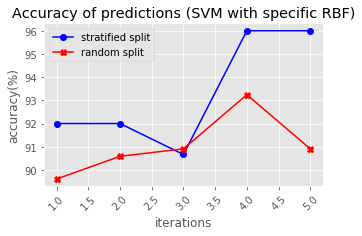

In [14]:
#using rbf kernel
from sklearn.svm import SVC 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import numpy as np

#find the best parameters
split = 100
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, train_size=split, test_size=num_sample-split)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(data, labels)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

#actually fit the data and get the result
cv.get_n_splits(data,labels)
clf = SVC(C=grid.best_params_['C'], gamma=grid.best_params_['gamma'])

#firstly try the stratified one
accuracies1 = []
accuracies2 = []
iterations = [1,2,3,4,5]
iteration = 0

print("stratified splitting")
for train_index, test_index in cv.split(data, labels):
    iteration += 1
    print("\niteration",iteration)
    training_data = []
    testing_data = []
    training_label = []
    testing_label = []
    for i in train_index:
        training_data.append(data[i])
        training_label.append(labels[i])
    for i in test_index:
        testing_data.append(data[i])
        testing_label.append(labels[i])
        
    clf.fit(training_data, training_label)
    prediction2 = clf.predict(testing_data)
    accuracy = analyze_prediction(prediction2,testing_label)
    accuracies1.append(accuracy)

#then try the random splitting

print("\nrandom splitting")
for i in range(5):
    training_data = []
    testing_data = []
    training_label = []
    testing_label = []
    
    splitData_random(100/175, training_data, testing_data, training_label, testing_label)
    print("\niteration",i+1)
    clf.fit(training_data, training_label) 
    prediction2 = clf.predict(testing_data)
    accuracy = analyze_prediction(prediction2,testing_label)
    accuracies2.append(accuracy)
    
#plot the result
plt.style.use('ggplot')
plt.figure(figsize=(5,3))
plt.title("Accuracy of predictions (SVM with specific RBF)")
plt.xlabel("iterations")
plt.xticks(rotation=45)
plt.ylabel("accuracy(%)")

plt.plot(iterations,accuracies1,color='b', label="stratified split", marker="o")
plt.plot(iterations,accuracies2,color='r',label="random split",marker="X")

plt.legend()
plt.grid(True)


# Conclusion
- for a **high-dimensional** problem like signature verification, **ordinary svm** cannot give satisfying result (accuracy is only **67%-70%**)
- Using **GridSearchCV** can give a quite satisfying result, as it can find good parameters to do the training
- comparing linear kernel and RBF kernel, RBF kernel is better (accuracy for **linear kernel** is **84%-93%**, while accuracy for **RBF kernel** is **90%-96%**)
- simple splitting gives very constant accuracy rate, while stratified splitting and random splitting gives fluctuating rate
- In general, **stratified splitting > random splitting > simple splitting** and **RBF kernel > linear kernel > ordinary SVM**

## Appendix
- the content of the python file. it's okay to just test here
- it utilizes the RBF kernel with GridSearchCV employed
- Note: as we have size requirement for the image, **a signature that's too small may not be able to predict**
- note that the path stored in csv file is **not** the whole path. You have to **append 'sig/' before** to make it a full path

In [1]:
import csv
import random
import numpy as np
from PIL import Image # pip install pillow
from skimage.filters import threshold_local # pip install scikit-image

from sklearn.svm import SVC 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

#########functions for image processing###########

# area of bounding box
def rotate_bbox_area(img, deg):
    box = img.rotate(deg, expand=True).getbbox()
    return (box[3] - box[1]) * (box[2] - box[0])
    
def rotate_crop(img, deg, padding=0):
    img_rotate = img.rotate(deg, expand=True, resample=Image.BILINEAR)
    box = img_rotate.getbbox()
    if padding > 0:
        box = np.asarray(box) + [-padding, -padding, +padding, +padding]
    return img_rotate.crop(box)

tol_deg = 10
# smallest bounding box wihin -10~10 degrees rotation
def opt_rotate(img, padding=0):
    opt_deg = np.argmin(
        [rotate_bbox_area(img, i) for i in range(-tol_deg,tol_deg+1)]
        ) - tol_deg
    return rotate_crop(img, opt_deg, padding)

# downsampling
def img_reduce(img, side=28, mode=Image.ANTIALIAS):
    h = side + 1 
    #w = int(side * img.width / img.height) + 1
    w = side + 1
    img_reduced = img.copy()
    # the reduced image size is (w-1, h-1)
    img_reduced.thumbnail((w, h), mode)
    return img_reduced

# convert PIL.Image object to numpy.Array, for training
def img2arr(img):
    return np.asarray(img.getdata(), dtype=np.uint8).reshape(img.height,img.width, -1)
    #return np.asarray(img.getdata(), dtype=np.uint8).reshape(28,28, -1)
    #return np.asarray(img.getdata(), dtype=np.uint8)

# process single signature with transparent background
def process_one(img):
    return img_reduce(opt_rotate(img, padding=1).convert('LA'))


#########functions to split the data samples###############

def splitData_simple(split, training_data = [], testing_data = [], training_label = [], testing_label=[]):
    for i in range(0,split):
        training_data.append(data[i])
        training_label.append(labels[i])
    for i in range(split,len(data)):
        testing_data.append(data[i])
        testing_label.append(labels[i])
    
def splitData_random(split, training_data = [], testing_data = [], training_label = [], testing_label=[]):
    for i in range(len(data)):
        if random.random() < split:
            training_data.append(data[i])
            training_label.append(labels[i])
        else:
            testing_data.append(data[i])
            testing_label.append(labels[i])

##########function to analyze the accuracy of prediction##############

def analyze_prediction(prediction,testing_label):
    num = len(testing_label)
    accuracy = 0.0
    for i in range(0,num):
        print("prediction:",prediction[i],";label:",testing_label[i])
        if prediction[i]==testing_label[i]:
            accuracy+=1
    accuracy/=float(num)
    return accuracy*100.00

###########global variables declared###############
data = []
labels = []
clf = None

##########training function#######################33

def train():

    global data, labels, clf
    #############load the csv file################

    with open('sig/png.csv', 'r') as csvfile:
        lines = csv.reader(csvfile)
        image_path=list(lines)

    #delete the first line, which is the column names
    del image_path[0]
    num_sample = len(image_path)

    random.shuffle(image_path)

    ############load the image and process image, load labels##########

    for i in range(num_sample):
        im = Image.open('sig/'+image_path[i][3]) #relative path to file
        img = im.convert('LA')
        
        #optimally rotate it and reduce the dimension of it
        img_reduced = process_one(img)
        
        #convert the image data to a 2d array and further convert to a 1D array
        img_arr = img2arr(img_reduced)[:,:,-1] # use the alpha channel, highter more opaque
        img_arr = img_arr.ravel()
        
        #if the dimension is too small, throw it away
        if len(img_arr)<319:
            img.close()
            im.close()
            continue
        
        #only append the first 319 values of an image
        data.append(img_arr[:319])
        if image_path[i][4]=='genuine':
            labels.append(0)
        else:
            labels.append(1)
        img.close()
        im.close()

    num_sample = len(data)

    split = 100
    C_range = np.logspace(-2, 10, 13)
    gamma_range = np.logspace(-9, 3, 13)
    param_grid = dict(gamma=gamma_range, C=C_range)
    cv = StratifiedShuffleSplit(n_splits=5, train_size=split, test_size=num_sample-split)
    grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
    grid.fit(data, labels)

    cv.get_n_splits(data,labels)
    clf = SVC(C=grid.best_params_['C'], gamma=grid.best_params_['gamma'])

    clf.fit(data, labels)

def test(path):

    global clf

    im = Image.open(path) #relative path to file
    img = im.convert('LA')
    #optimally rotate it and reduce the dimension of it
    img_reduced = process_one(img)
    #convert the image data to a 2d array and further convert to a 1D array
    img_arr = img2arr(img_reduced)[:,:,-1] # use the alpha channel, highter more opaque
    img_arr = img_arr.ravel()
    img_arr = img_arr[:319]

    testing_data = []
    testing_data.append(img_arr)

    try:
        result = clf.predict(testing_data)
    except:
        return "signature too small"
    
    finalResult = result[0]
    if finalResult==0:
        return True
    else:
        return False


In [2]:
train()

In [3]:
print(test('sig/original/1f4f45f8-86cb5dc3.png'))
print(test('sig/478f69bb-.png'))

False
True
